In [27]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [28]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device ='cpu'
print(device)

cpu


In [29]:
data_df=pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [30]:
data_df.dropna(inplace = True)
data_df.drop(['id'],axis=1,inplace=True)
print(data_df.shape)

(18185, 11)


In [31]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [32]:
print(data_df["Class"].unique())

[1 0]


In [33]:
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


**The dataset is not perfectly balanced dataset**

In [34]:
original_df=data_df.copy()

for col in data_df.columns:
  data_df[col] = data_df[col]/data_df[col].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [35]:
X = np.array(data_df.iloc[:,:-1])   # get all the columns and rows except the last column class
Y = np.array(data_df.iloc[:,-1])     #all rows and last column only (class column)

In [36]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size= 0.3)

In [37]:
X_test,X_val,y_test,y_val = train_test_split(X_test,Y_test,test_size=0.5)

In [38]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [39]:
class dataset(Dataset):
  def __init__(self, X,Y):
    self.X=torch.tensor(X, dtype = torch.float32).to(device)
    self.Y=torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

training_data=dataset(X_train,Y_train)
validation_data=dataset(X_val,y_val)
testing_data=dataset(X_test,Y_test)

In [40]:
testing_data[0]

(tensor([0.9123, 0.8895, 0.8924, 0.9226, 0.8694, 0.9552, 0.7368, 0.7652, 0.8544,
         0.5655]),
 tensor(0.))

In [77]:
train_dataloader=DataLoader(training_data,batch_size=32,shuffle=True)
validation_dataloader= DataLoader(validation_data,batch_size=32,shuffle=True)
test_dataloader= DataLoader(testing_data, batch_size=32, shuffle=True)

In [71]:
for x,y in train_dataloader:
  print(x)
  print("========")
  print(y)
  break

tensor([[0.8449, 0.8665, 0.8556, 0.9264, 0.8089, 0.9192, 0.6331, 0.7473, 0.8297,
         0.5746],
        [0.5308, 0.7561, 0.6070, 0.9643, 0.5035, 0.7285, 0.5886, 0.6198, 0.7576,
         0.7067],
        [0.7105, 0.7663, 0.8133, 0.9084, 0.6798, 0.8429, 0.7905, 0.6726, 0.8613,
         0.5345],
        [0.5908, 0.8399, 0.6182, 0.9758, 0.5669, 0.7686, 0.5276, 0.6815, 0.6976,
         0.7708],
        [0.6193, 0.8694, 0.6352, 0.9767, 0.5995, 0.7870, 0.8324, 0.7010, 0.6911,
         0.7766],
        [0.5659, 0.7660, 0.6425, 0.9577, 0.5393, 0.7523, 0.8026, 0.6392, 0.7595,
         0.6764],
        [0.7254, 0.8155, 0.7753, 0.9346, 0.6899, 0.8517, 0.8292, 0.7296, 0.7472,
         0.5967],
        [0.6308, 0.8902, 0.6197, 0.9822, 0.6008, 0.7942, 0.5311, 0.7054, 0.6951,
         0.8150],
        [0.5926, 0.8558, 0.6037, 0.9807, 0.5628, 0.7698, 0.7711, 0.6781, 0.7068,
         0.8043],
        [0.8412, 0.8539, 0.8548, 0.9232, 0.7997, 0.9172, 0.8929, 0.7326, 0.8595,
         0.5667],
        [0

In [72]:
HIDDEN_NEURONS= 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel,self).__init__()

    self.input_layer = nn.Linear(x.shape[1],HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS,1)
    self.sigmoid = nn.Sigmoid()


  def forward(self,x):
    x= self.input_layer(x)
    x= self.linear(x)
    x= self.sigmoid(x)
    return x

model = MyModel().to(device)

In [73]:
summary(model, (x.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [74]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr=0.001)

In [75]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 10
for epoch in range(epochs):
  total_acc_train=0
  total_loss_train=0
  total_acc_val=0
  total_loss_val=0

  for data in train_dataloader:
    inputs,labels =data

    prediction= model(inputs).squeeze(1) # prediction shape is [8,1] but label is [8] only so we need to squeeze it only

    batch_loss = criterion(prediction,labels)
    #print(batch_loss)
    total_loss_train += batch_loss.item()

    acc= ((prediction).round() == labels).sum().item()
    total_acc_train += acc
    #print(acc)

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()


    ######### Validation ################
  with torch.no_grad():
    for data in validation_dataloader:
      inputs,labels = data

      prediction= model(inputs).squeeze(1)

      batch_loss = criterion(prediction,labels)
      total_loss_val += batch_loss.item()
      #print(total_loss_val)

      acc= ((prediction).round() == labels).sum().item()
      total_acc_val += acc
      #print(total_acc_val)

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*100)



Epoch no. 1 Train Loss: 0.2363 Train Accuracy: 85.0892 Validation Loss: 0.0403 Validation Accuracy: 95.1613
Epoch no. 2 Train Loss: 0.1303 Train Accuracy: 97.4232 Validation Loss: 0.0179 Validation Accuracy: 97.5073
Epoch no. 3 Train Loss: 0.0609 Train Accuracy: 98.1538 Validation Loss: 0.0097 Validation Accuracy: 97.8006
Epoch no. 4 Train Loss: 0.0378 Train Accuracy: 98.4052 Validation Loss: 0.0069 Validation Accuracy: 98.1305
Epoch no. 5 Train Loss: 0.0287 Train Accuracy: 98.5388 Validation Loss: 0.0056 Validation Accuracy: 98.0938
Epoch no. 6 Train Loss: 0.0241 Train Accuracy: 98.5623 Validation Loss: 0.0049 Validation Accuracy: 98.2771
Epoch no. 7 Train Loss: 0.0214 Train Accuracy: 98.6095 Validation Loss: 0.0046 Validation Accuracy: 98.0938
Epoch no. 8 Train Loss: 0.0198 Train Accuracy: 98.6645 Validation Loss: 0.0041 Validation Accuracy: 98.3138
Epoch no. 9 Train Loss: 0.0189 Train Accuracy: 98.5938 Validation Loss: 0.0041 Validation Accuracy: 98.1305
Epoch no. 10 Train Loss: 0.0

In [78]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in test_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 53.23%


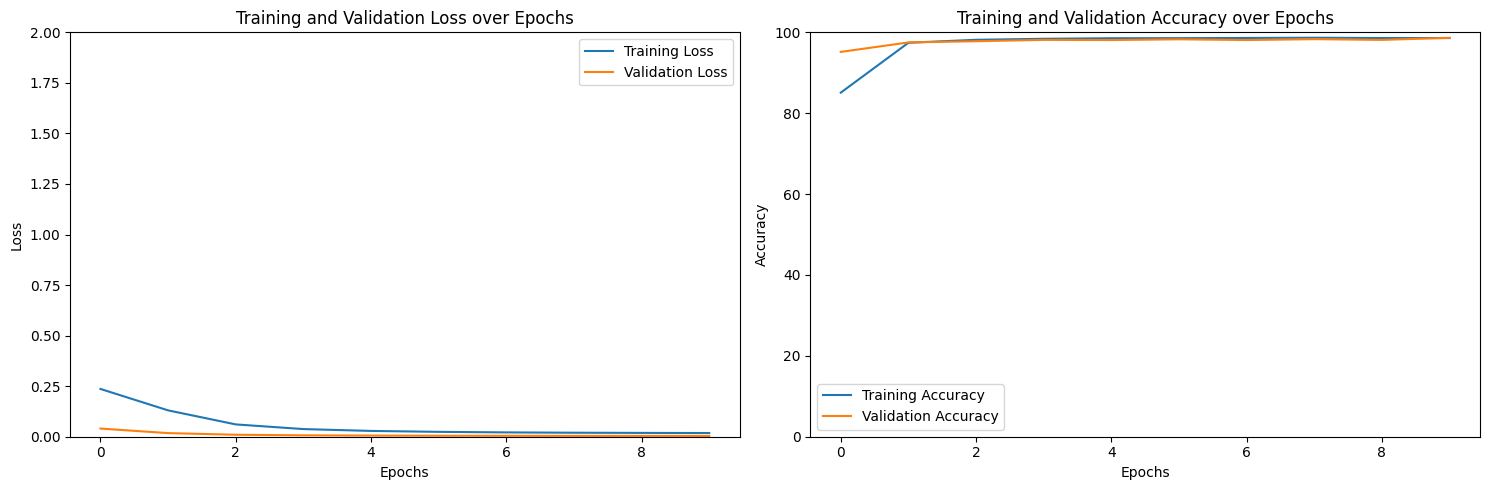

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [80]:
area = float(input("Area: "))/original_df['Area'].abs().max()
MajorAxisLength = float(input("Major Axis Length: "))/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = float(input("Minor Axis Length: "))/original_df['MinorAxisLength'].abs().max()
Eccentricity = float(input("Eccentricity: "))/original_df['Eccentricity'].abs().max()
ConvexArea = float(input("Convex Area: "))/original_df['ConvexArea'].abs().max()
EquivDiameter = float(input("EquivDiameter: "))/original_df['EquivDiameter'].abs().max()
Extent = float(input("Extent: "))/original_df['Extent'].abs().max()
Perimeter = float(input("Perimeter: "))/original_df['Perimeter'].abs().max()
Roundness = float(input("Roundness: "))/original_df['Roundness'].abs().max()
AspectRation = float(input("AspectRation: "))/original_df['AspectRation'].abs().max()

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)
model_inputs = torch.Tensor(my_inputs).to(device)
prediction = (model(model_inputs))
print(prediction)
print("Class is: ", round(prediction.item()))


Area: 6431.279
Major Axis Length: 145.21338
Minor Axis Length: 56.902
Eccentricity: 0.919981821
Convex Area: 6518.93759999
EquivDiameter: 90.483541
Extent: 0.8506668
Perimeter: 329.972
Roundness: 0.742255516
AspectRation: 2.551696
tensor([0.7405], grad_fn=<SigmoidBackward0>)
Class is:  1
